In [ ]:
# !wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fslconda/releases/fslinstaller.py

In [ ]:
# !python3 fslinstaller.py -V 6.0.6.2 -d /usr/local/fsl --yes

In [14]:
# import os

# os.environ["FSLDIR"] = "/usr/local/fsl"
# os.environ["PATH"] += ":/usr/local/fsl/bin"
# os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"

In [ ]:
# import subprocess

# result = subprocess.run(["flirt", "-version"], capture_output=True, text=True)
# print(result.stdout)

In [ ]:
# !apt-get update
# !apt-get install -y bc
# !apt-get install -y dc

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urllib.request
import tarfile
import glob
import os
import nibabel as nib

Wszystkie poniższe wizualizacje zostały wykonane z wykorzystaniem zbioru **IXI Dataset**
https://brain-development.org/ixi-dataset/

In [104]:
from google.colab import files
uploaded = files.upload()

Saving brainage-prediction-mri-main.zip to brainage-prediction-mri-main.zip
Saving IXI.xls to IXI.xls
Saving mri_data.csv to mri_data.csv
Saving output_predictions.csv to output_predictions.csv
Saving output_predictions_our_model.csv to output_predictions_our_model.csv


Opis używanych tabel:
*   IXI.xls - dane demograficzne dotyczące zbioru obrazów IXI,
*   mri_data.csv - zbiór danych obrazowych przekształcony do formatu csv z dodanymi kolumnami 'age_at_scan' i 'partition' (podział na zbiory treningowy, walidacyjny i testowy),
*   output_predictions.csv - predykcje oryginalnego modelu na danych testowych IXI ('uid', 'age_at_scan', 'predicted_age'),
*   output_predictions_our_model.csv - predykcje naszego modelu na danych testowych IXI.


In [24]:
ixi_metadata = pd.read_excel("IXI.xls")
mri_data = pd.read_csv("mri_data.csv")
new_model_preds = pd.read_csv("output_predictions_our_model.csv")
original_model_preds = pd.read_csv("output_predictions.csv")

new_model_preds["uid"] = new_model_preds["uid"].str.extract(r'tensor\((\d+)\)').astype(int)
original_model_preds["uid"] = original_model_preds["uid"].str.extract(r'tensor\((\d+)\)').astype(int)

In [ ]:
if ixi_metadata['IXI_ID'].duplicated().sum() > 0:
  dupl_count = ixi_metadata['IXI_ID'].duplicated().sum()
  print(f"W zbiorze ixi_metadata jest {dupl_count} duplikatów `IXI_ID` (czyli osób z wieloma skanami MRI).")
else:
  print("W zbiorze ixi_metadata nie powtarzają się osoby (IXI_ID).")

W zbiorze ixi_metadata jest 26 duplikatów `IXI_ID` (czyli osób z wieloma skanami MRI).


### IXI T1 images dataset

In [ ]:
import urllib.request

url = "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar"
tar_path = "pliki_mri.tar.gz"

urllib.request.urlretrieve(url, tar_path)

In [11]:
with tarfile.open(tar_path, "r:") as tar:
    tar.extractall("/content/nifti_data")

In [ ]:
# !pip install nipype

In [ ]:
!unzip brainage-prediction-mri-main.zip

Przestrzenne wyrównanie obrazów MRI T1-w do wzorca MNI za pomocą skryptu autorów artykułu.

In [ ]:
!python3 ./brainage-prediction-mri-main/brain_age_trainer_preprocessing.py --input-csv mri_data.csv --output-dir /content/nifti_data/registered --output-csv mri_data_registered.csv

### Porównanie obrazów MRI mózgu kobiet i mężczyzn w różnym wieku - po normalizacji do przestrzeni MNI

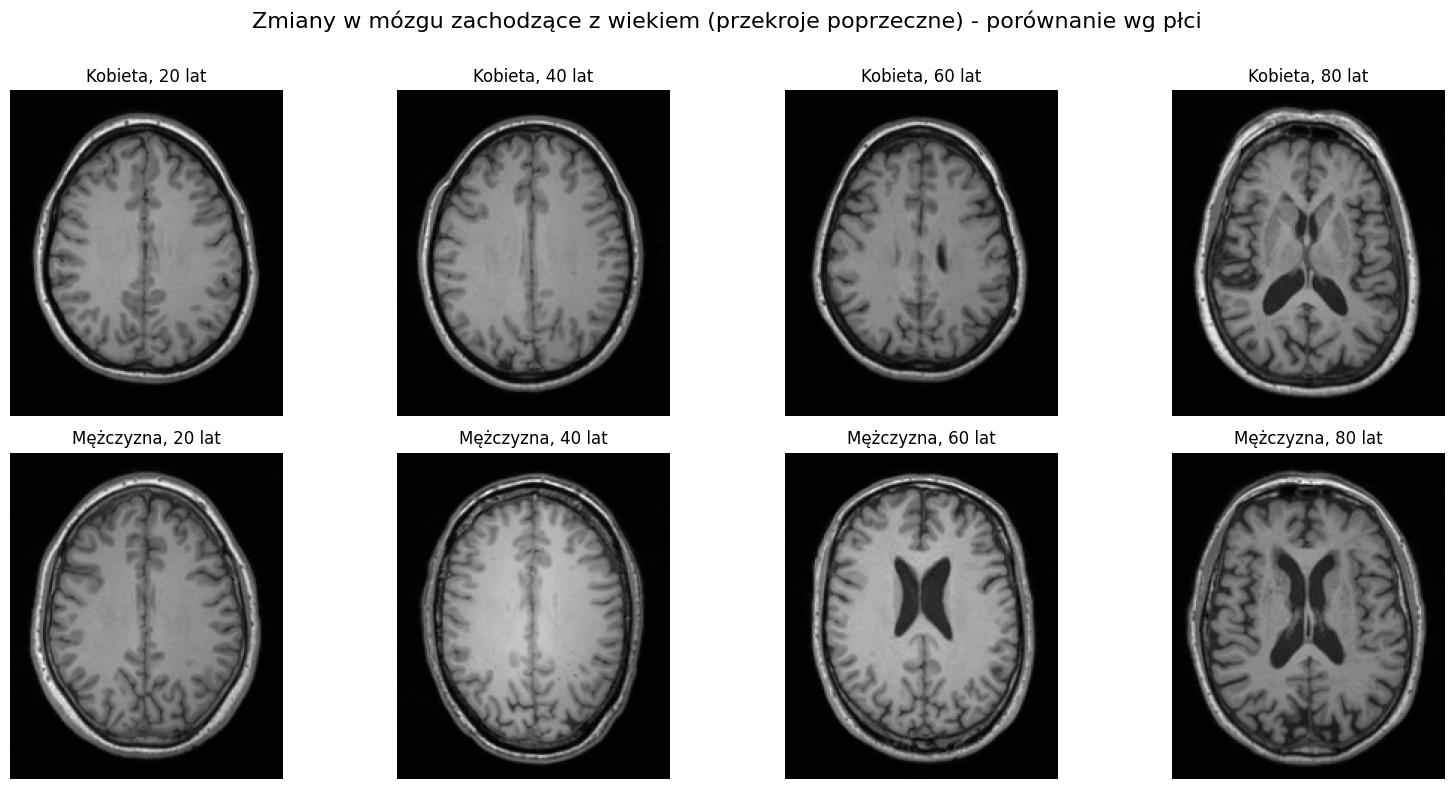

In [74]:
mri_df = pd.read_csv("mri_data_registered.csv")
ixi_metadata["AGE"] = ixi_metadata["AGE"].astype(str).str.replace(",", ".").astype(float).apply(np.floor)

women_ids = [f"IXI{num:03d}" for num in [70, 45, 197, 251]]
men_ids = [f"IXI{num:03d}" for num in [64, 282, 182, 640]]

def load_slice_axial(uid):
    try:
        uid_int = int(uid.replace("IXI", ""))
    except ValueError:
        print(f"Nieprawidłowy identyfikator: {uid}")
        return None

    row = mri_df[mri_df["uid"] == uid_int]
    if not row.empty:
        path = row.iloc[0]["path_registered"]
        try:
            img = nib.load(path)
            data = img.get_fdata()
            affine = img.affine
            coord_mm = [0, 0, 30]
            voxel_index = np.round(np.linalg.inv(affine).dot(coord_mm + [1])).astype(int)
            z_index = voxel_index[2]
            return data[:, :, z_index]
        except Exception as e:
            print(f"Błąd ładowania {path}: {e}")
    else:
        print(f"Nie znaleziono danych dla uid: {uid_int}")
    return None

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Zmiany w mózgu zachodzące z wiekiem (przekroje poprzeczne) - porównanie wg płci", fontsize=16)

ages = [20, 40, 60, 80]

for i, uid in enumerate(women_ids):
    slice_data = load_slice_axial(uid)
    if slice_data is not None:
        axes[0, i].imshow(slice_data.T, cmap='gray', origin='lower')
        axes[0, i].set_title(f'Kobieta, {ages[i]} lat')
    axes[0, i].axis('off')

for i, uid in enumerate(men_ids):
    slice_data = load_slice_axial(uid)
    if slice_data is not None:
        axes[1, i].imshow(slice_data.T, cmap='gray', origin='lower')
        axes[1, i].set_title(f'Mężczyzna, {ages[i]} lat')
    axes[1, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

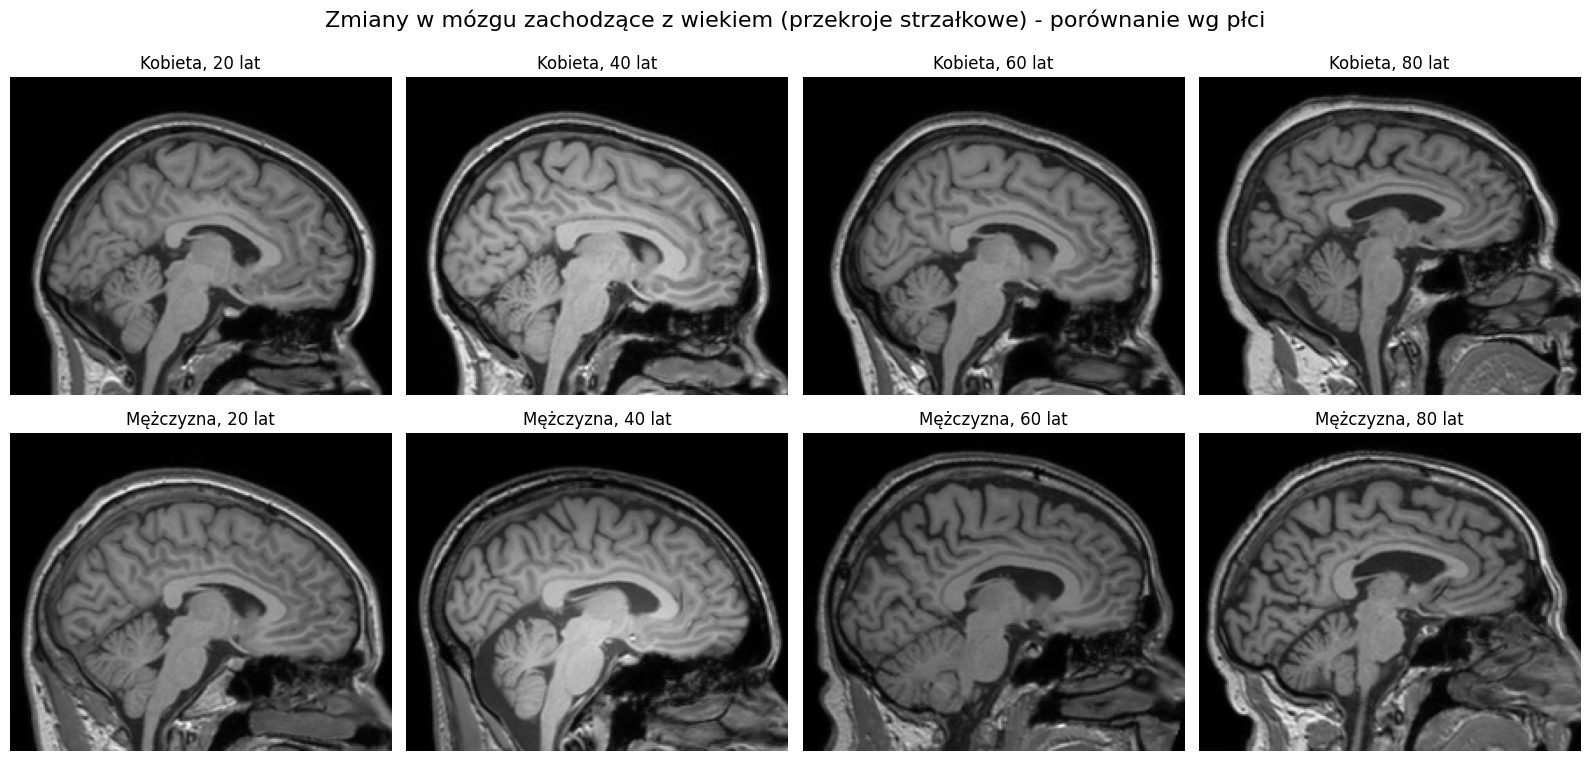

In [86]:
def load_slice_sagittal(uid):
    try:
        uid_int = int(uid.replace("IXI", ""))
    except ValueError:
        print(f"Nieprawidłowy identyfikator: {uid}")
        return None

    row = mri_df[mri_df["uid"] == uid_int]
    if not row.empty:
        path = row.iloc[0]["path_registered"]
        try:
            img = nib.load(path)
            data = img.get_fdata()
            affine = img.affine
            coord_mm = [5, 0, 0]
            voxel_index = np.round(np.linalg.inv(affine).dot(coord_mm + [1])).astype(int)
            x_index = voxel_index[0]
            return data[x_index, :, :]
        except Exception as e:
            print(f"Błąd ładowania {path}: {e}")
    else:
        print(f"Nie znaleziono danych dla uid: {uid_int}")
    return None

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Zmiany w mózgu zachodzące z wiekiem (przekroje strzałkowe) - porównanie wg płci", fontsize=16)

ages = [20, 40, 60, 80]

for i, uid in enumerate(women_ids):
    slice_data = load_slice_sagittal(uid)
    if slice_data is not None:
        axes[0, i].imshow(slice_data.T, cmap='gray', origin='lower')
        axes[0, i].set_title(f'Kobieta, {ages[i]} lat')
    axes[0, i].axis('off')

for i, uid in enumerate(men_ids):
    slice_data = load_slice_sagittal(uid)
    if slice_data is not None:
        axes[1, i].imshow(slice_data.T, cmap='gray', origin='lower')
        axes[1, i].set_title(f'Mężczyzna, {ages[i]} lat')
    axes[1, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

### **Histogram** rozkładu wieku w całym zbiorze IXI, z linią KDE

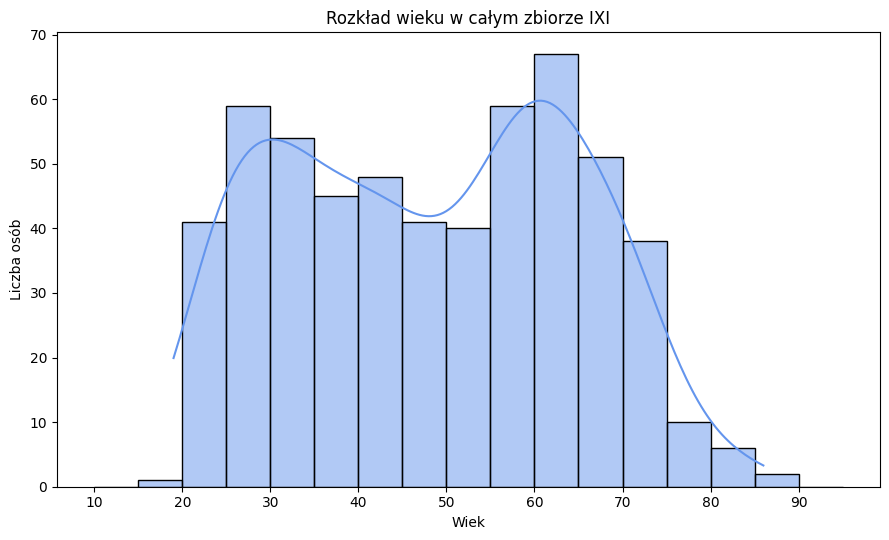

In [ ]:
# Filtrowanie: tylko potrzebne kolumny
filtered = mri_data[["uid", "age_at_scan"]]

# Histogram wieku w całym zbiorze IXI
plt.figure(figsize=(9, 5.5))

min_age = filtered["age_at_scan"].min()
max_age = filtered["age_at_scan"].max()

bins = range(int(min_age // 5) * 5, int(max_age // 5 + 1) * 5 + 1, 5)
bins = range(10, 100, 5)

sns.histplot(data=filtered, x="age_at_scan", bins=bins,
             color="cornflowerblue", edgecolor="black", kde=True)

plt.xlabel("Wiek")
plt.ylabel("Liczba osób")
plt.title("Rozkład wieku w całym zbiorze IXI")
plt.xticks(ticks=range(10, 100, 10))
plt.tight_layout()
plt.show()

In [ ]:
# Połączenie danych po uid (mri_data) i IXI_ID (ixi_metadata)
mri_data["uid"] = mri_data["uid"].astype(int)
ixi_metadata = ixi_metadata[["IXI_ID", "SEX_ID (1=m, 2=f)"]].drop_duplicates(subset="IXI_ID")
ixi_metadata["IXI_ID"] = ixi_metadata["IXI_ID"].astype(int)

merged = mri_data.merge(ixi_metadata, left_on="uid", right_on="IXI_ID", how="left")
merged["Płeć"] = merged["SEX_ID (1=m, 2=f)"].map({1: "Mężczyzna", 2: "Kobieta"})

# Obliczenie udziału płci w całym zbiorze
gender_pct_all = merged["Płeć"].value_counts(normalize=True) * 100
print("Udział płci w całym zbiorze:")
print((gender_pct_all.round(2).astype(str) + " %").to_string(index=True, header=False))

# Obliczenie udziału płci w zbiorach treningowym i walidacyjnym
train_val = merged[merged["partition"].isin(["train", "dev"])]
gender_pct_train_val = train_val["Płeć"].value_counts(normalize=True) * 100
print("\nUdział płci w zbiorach treningowym i walidacyjnym:")
print((gender_pct_train_val.round(2).astype(str) + " %").to_string(index=True, header=False))

Udział płci w całym zbiorze:
Kobieta      55.69 %
Mężczyzna    44.31 %

Udział płci w zbiorach treningowym i walidacyjnym:
Kobieta      54.51 %
Mężczyzna    45.49 %


### **Histogram** rozkładu wieku w połączonych zbiorach - treningowym i walidacyjnym, z podziałem na płeć

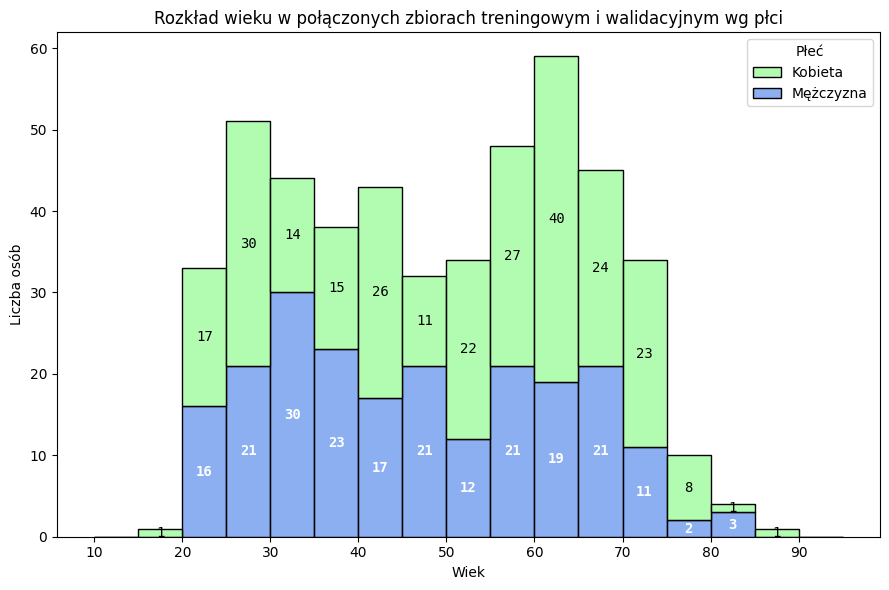

In [ ]:
# Połączenie danych po uid (mri_data) i IXI_ID (ixi_metadata)
mri_data["uid"] = mri_data["uid"].astype(int)
ixi_metadata = ixi_metadata[["IXI_ID", "SEX_ID (1=m, 2=f)"]].drop_duplicates(subset="IXI_ID")
ixi_metadata["IXI_ID"] = ixi_metadata["IXI_ID"].astype(int)

merged = mri_data.merge(ixi_metadata, left_on="uid", right_on="IXI_ID", how="left")

# Filtrowanie: tylko train + val i tylko potrzebne kolumny
filtered = merged[merged["partition"].isin(["train", "dev"])]
filtered = filtered[["uid", "age_at_scan", "SEX_ID (1=m, 2=f)"]]

min_age = filtered["age_at_scan"].min()
max_age = filtered["age_at_scan"].max()

bins = range(int(min_age // 5) * 5, int(max_age // 5 + 1) * 5 + 1, 5)
bins = range(10, 100, 5)

# Zamiana płci na etykiety
filtered["Płeć"] = filtered["SEX_ID (1=m, 2=f)"].map({1: "Mężczyzna", 2: "Kobieta"})

filtered["bin"] = pd.cut(filtered["age_at_scan"], bins=bins, right=False)
counts = filtered.groupby(["bin", "Płeć"], observed=False).size().unstack(fill_value=0)
bin_centers = [interval.left + (interval.right - interval.left)/2 for interval in counts.index]

# Histogram rozkładu wieku z podziałem na płeć
plt.figure(figsize=(9, 6))

sns.histplot(data=filtered, x="age_at_scan", hue="Płeć", bins=bins, multiple="stack",
             palette={"Mężczyzna": "cornflowerblue", "Kobieta": "palegreen"}, edgecolor="black")

# Dodanie etykiet liczebności
for i, center in enumerate(bin_centers):
    y_m = counts.iloc[i]["Mężczyzna"]
    y_k = counts.iloc[i]["Kobieta"]

    if y_m > 0:
        plt.text(center, y_m / 2, str(y_m), ha='center', va='center', fontsize=10, weight='bold', fontfamily='monospace', color='white')
    if y_k > 0:
        plt.text(center, y_m + y_k / 2, str(y_k), ha='center', va='center', fontsize=10, fontfamily='monospace', color='black')

plt.xlabel("Wiek")
plt.ylabel("Liczba osób")
plt.title("Rozkład wieku w połączonych zbiorach treningowym i walidacyjnym wg płci")
plt.xticks(ticks=range(10, 100, 10))
plt.tight_layout()
plt.show()

### Wyniki predykcji obydwu modeli na zbiorze testowym IXI

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [27]:
y_true_new = new_model_preds['age_at_scan']
y_pred_new = new_model_preds['predicted_age']

y_true = original_model_preds['age_at_scan']
y_pred = original_model_preds['predicted_age']

# Obliczenia metryk
mae = mean_absolute_error(y_true_new, y_pred_new)
mse = mean_squared_error(y_true_new, y_pred_new)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_new, y_pred_new)
pearson_r, _ = pearsonr(y_true_new, y_pred_new)

mae_1 = mean_absolute_error(y_true, y_pred)
mse_1 = mean_squared_error(y_true, y_pred)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_true, y_pred)
pearson_r_1, _ = pearsonr(y_true, y_pred)

print("Wyniki predykcji naszego modelu:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Pearson r: {pearson_r:.3f}")
print("\nWyniki predykcji oryginalnego modelu:")
print(f"MAE: {mae_1:.3f}")
print(f"RMSE: {rmse_1:.3f}")
print(f"R^2: {r2_1:.3f}")
print(f"Pearson r: {pearson_r_1:.3f}")

Wyniki predykcji naszego modelu:
MAE: 6.259
RMSE: 7.785
R^2: 0.781
Pearson r: 0.884

Wyniki predykcji oryginalnego modelu:
MAE: 12.674
RMSE: 15.930
R^2: 0.084
Pearson r: 0.875


### **Boxploty** - porównanie rozkładu wieku w zbiorze testowym IXI i w predykcjach obydwu modeli

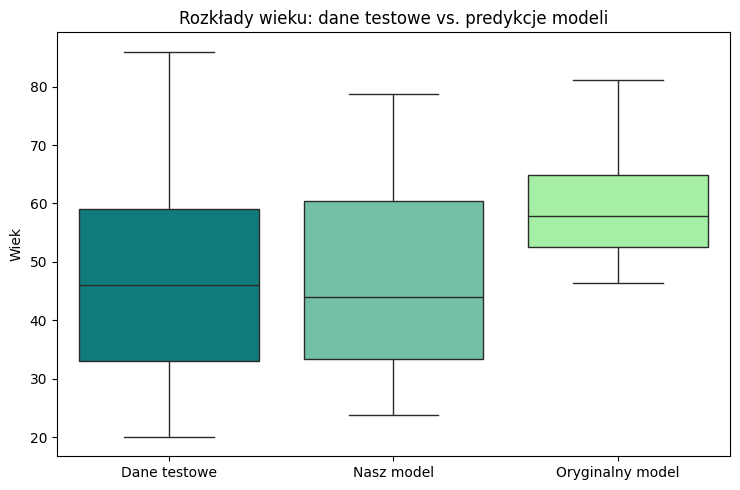

In [ ]:
true_ages = new_model_preds[["age_at_scan"]].copy()
true_ages["source"] = "Dane testowe"
true_ages.rename(columns={"age_at_scan": "age"}, inplace=True)

# Przetworzenie predykcji modelu new
new_model_df = new_model_preds[["predicted_age"]].copy()
new_model_df["source"] = "Nasz model"
new_model_df.rename(columns={"predicted_age": "age"}, inplace=True)

# Przetworzenie predykcji modelu original
original_model_df = original_model_preds[["predicted_age"]].copy()
original_model_df["source"] = "Oryginalny model"
original_model_df.rename(columns={"predicted_age": "age"}, inplace=True)

# Połączenie do jednego DataFrame
combined = pd.concat([true_ages, new_model_df, original_model_df], ignore_index=True)

# Wykres: boxploty rozkładu wieku - test data/new model/original model
plt.figure(figsize=(7.5, 5))

sns.boxplot(
    data=combined,
    x="source",
    y="age",
    hue="source",
    palette={
        "Dane testowe": "#008B8B",
        "Nasz model": "#66CDAA",
        "Oryginalny model": "palegreen"
    },
    showfliers=True,
    fliersize=4,
    linewidth=1,
    flierprops=dict(marker='D', markerfacecolor='black', markersize=4, linestyle='none')
)

plt.grid(False)
plt.ylabel("Wiek")
plt.xlabel("")
plt.title("Rozkłady wieku: dane testowe vs. predykcje modeli")
plt.tight_layout()
plt.show()

### **Scatter plot** predykcji naszego modelu - z linią idealnego dopasowania, linią regresji i podziałem według płci

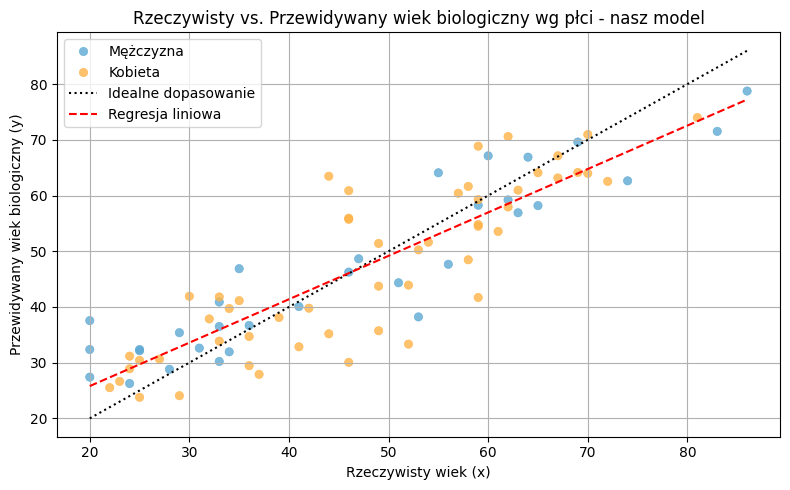

In [ ]:
# Połączenie tabel po identyfikatorze (uid = IXI_ID)
merged = new_model_preds.merge(ixi_metadata[["IXI_ID", "SEX_ID (1=m, 2=f)"]].drop_duplicates(subset="IXI_ID"), left_on="uid", right_on="IXI_ID", how="left")

# Zamiana wartości płci na etykiety
merged["Płeć"] = merged["SEX_ID (1=m, 2=f)"].map({1: "Mężczyzna", 2: "Kobieta"})

# Wykres: scatter plot z linią idealną, linią regresji i kolorem wg płci
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=merged,
    x="age_at_scan",
    y="predicted_age",
    hue="Płeć",
    palette={"Mężczyzna": "#5CA9D4", "Kobieta": "#FFB347"},
    alpha=0.8,
    edgecolor=None
)

# Linia idealna: y = x
min_val = min(merged["age_at_scan"].min(), merged["predicted_age"].min())
max_val = max(merged["age_at_scan"].max(), merged["predicted_age"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle=":", color="black", label="Idealne dopasowanie")

# Linia regresji
coeffs = np.polyfit(merged["age_at_scan"], merged["predicted_age"], deg=1)
reg_x = np.linspace(min_val, max_val, 100)
reg_y = coeffs[0] * reg_x + coeffs[1]
plt.plot(reg_x, reg_y, linestyle="--", color="red", label="Regresja liniowa")

plt.xlabel("Rzeczywisty wiek (x)")
plt.ylabel("Przewidywany wiek biologiczny (y)")
plt.title("Rzeczywisty vs. Przewidywany wiek biologiczny wg płci - nasz model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Scatter plot** predykcji oryginalnego modelu na zbiorze testowym IXI - z linią idealnego dopasowania, linią regresji i podziałem według płci

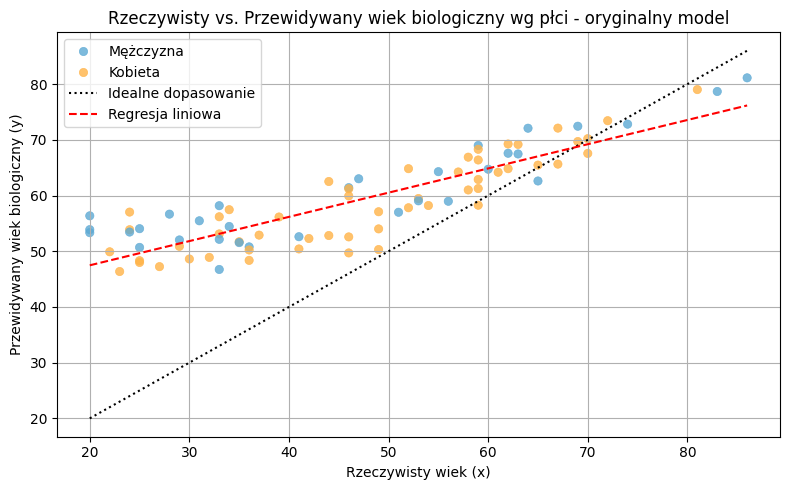

In [ ]:
# Połączenie tabel po identyfikatorze (uid = IXI_ID)
merged = original_model_preds.merge(ixi_metadata[["IXI_ID", "SEX_ID (1=m, 2=f)"]].drop_duplicates(subset="IXI_ID"), left_on="uid", right_on="IXI_ID", how="left")

# Zamiana wartości płci na etykiety
merged["Płeć"] = merged["SEX_ID (1=m, 2=f)"].map({1: "Mężczyzna", 2: "Kobieta"})

# Wykres: scatter plot z linią idealną, linią regresji i kolorem wg płci
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=merged,
    x="age_at_scan",
    y="predicted_age",
    hue="Płeć",
    palette={"Mężczyzna": "#5CA9D4", "Kobieta": "#FFB347"},
    alpha=0.8,
    edgecolor=None
)

# Linia idealna: y = x
min_val = min(merged["age_at_scan"].min(), merged["predicted_age"].min())
max_val = max(merged["age_at_scan"].max(), merged["predicted_age"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle=":", color="black", label="Idealne dopasowanie")

# Linia regresji
coeffs = np.polyfit(merged["age_at_scan"], merged["predicted_age"], deg=1)
reg_x = np.linspace(min_val, max_val, 100)
reg_y = coeffs[0] * reg_x + coeffs[1]
plt.plot(reg_x, reg_y, linestyle="--", color="red", label="Regresja liniowa")

plt.xlabel("Rzeczywisty wiek (x)")
plt.ylabel("Przewidywany wiek biologiczny (y)")
plt.title("Rzeczywisty vs. Przewidywany wiek biologiczny wg płci - oryginalny model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Scatter plot** - zależność między predykcjami wieku mózgu naszego modelu i modelu oryginalnego

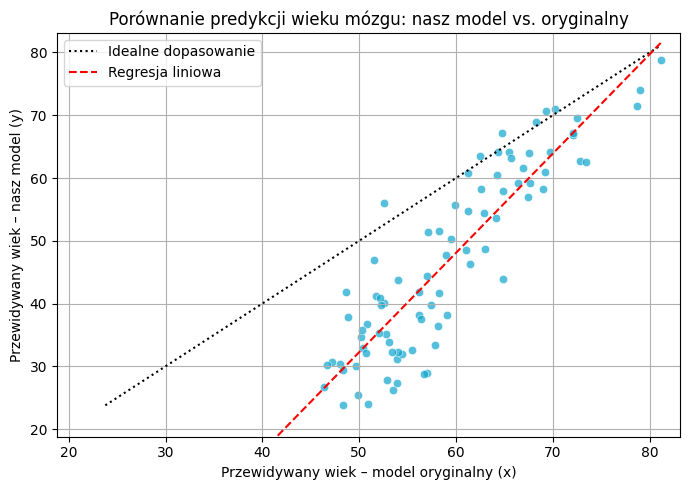

In [ ]:
# Połączenie predykcji dwóch modeli po uid
comparison = new_model_preds[["uid", "predicted_age"]].rename(columns={"predicted_age": "new_model"})
comparison = comparison.merge(
    original_model_preds[["uid", "predicted_age"]].rename(columns={"predicted_age": "original_model"}),
    on="uid",
    how="inner"
)

# Scatterplot: predykcja modelu A vs. predykcja modelu B
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=comparison,
    x="original_model",
    y="new_model",
    alpha=0.7,
    color="#0fa5cc"
)

# Linia idealna: y = x
min_val = min(comparison["new_model"].min(), comparison["original_model"].min())
max_val = max(comparison["new_model"].max(), comparison["original_model"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle=":", color="black", label="Idealne dopasowanie")

# Linia regresji
coeffs = np.polyfit(comparison["original_model"], comparison["new_model"], deg=1)
reg_x = np.linspace(min_val, max_val, 100)
reg_y = coeffs[0] * reg_x + coeffs[1]
plt.plot(reg_x, reg_y, linestyle="--", color="red", label="Regresja liniowa")

plt.xlim(min_val-5, max_val+2)
plt.ylim(min_val-5, max_val+2)

plt.xlabel("Przewidywany wiek – model oryginalny (x)")
plt.ylabel("Przewidywany wiek – nasz model (y)")
plt.title("Porównanie predykcji wieku mózgu: nasz model vs. oryginalny")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### **Średni błąd bezwzględny** (MAE) predykcji w rzeczywistych przedziałach wiekowych - porównanie obydwu modeli

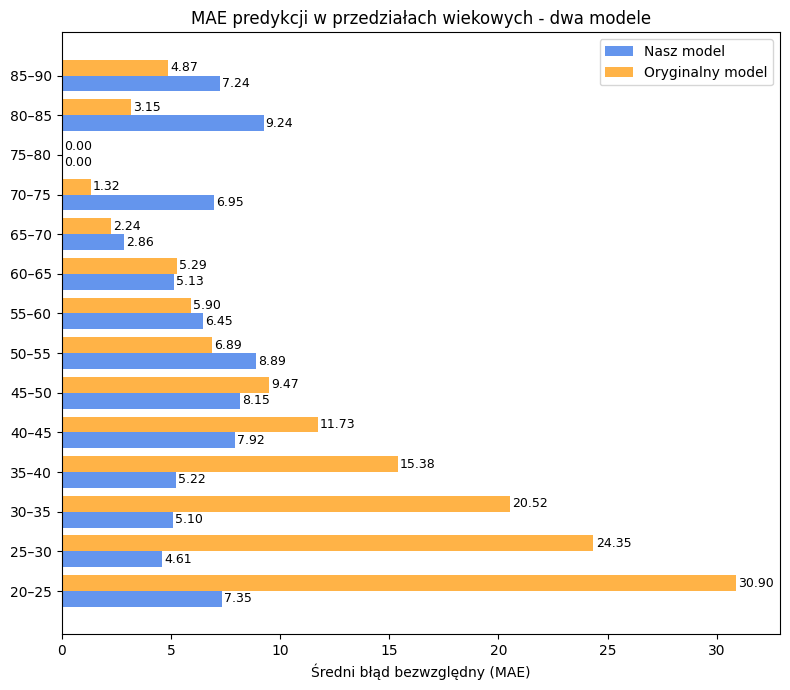

In [ ]:
bins = range(20, 95, 5)
new_model_preds["bin"] = pd.cut(new_model_preds["age_at_scan"], bins=bins, right=False)
original_model_preds["bin"] = pd.cut(original_model_preds["age_at_scan"], bins=bins, right=False)

all_bins = pd.Categorical(pd.cut(pd.Series(bins[:-1]), bins=bins, right=False).unique(), ordered=True)

# MAE dla naszego modelu
mae_new = new_model_preds.groupby("bin", observed=True).agg(
    MAE=("predicted_age", lambda x: np.mean(np.abs(x - new_model_preds.loc[x.index, "age_at_scan"])))
).reindex(all_bins).fillna(0)

# MAE dla oryginalnego modelu
mae_orig = original_model_preds.groupby("bin", observed=True).agg(
    MAE=("predicted_age", lambda x: np.mean(np.abs(x - original_model_preds.loc[x.index, "age_at_scan"])))
).reindex(all_bins).fillna(0)

# Przygotowanie etykiet
labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in all_bins]

y = np.arange(len(labels))
bar_height = 0.4

# Wykres słupkowy MAE w przedziałach wiekowych
plt.figure(figsize=(8, 7))
plt.barh(y - bar_height/2, mae_new["MAE"], height=bar_height, color="cornflowerblue", label="Nasz model")
plt.barh(y + bar_height/2, mae_orig["MAE"], height=bar_height, color="#FFB347", label="Oryginalny model")

# Dodanie etykiet na końcach słupków
for i, v in enumerate(mae_new["MAE"]):
    plt.text(v + 0.1, y[i] - bar_height/2, f"{v:.2f}", va="center", fontsize=9)

for i, v in enumerate(mae_orig["MAE"]):
    plt.text(v + 0.1, y[i] + bar_height/2, f"{v:.2f}", va="center", fontsize=9)

plt.yticks(ticks=y, labels=labels, ha='right')
plt.xlabel("Średni błąd bezwzględny (MAE)")
plt.xlim(0, max(mae_new["MAE"].max(), mae_orig["MAE"].max()) + 2)
plt.title("MAE predykcji w przedziałach wiekowych - dwa modele")
plt.legend()
plt.tight_layout()
plt.show()

### **Średni błąd bezwzględny** (MAE) predykcji naszego modelu z podziałem na płeć

In [ ]:
merged = new_model_preds.merge(ixi_metadata[["IXI_ID", "SEX_ID (1=m, 2=f)"]].drop_duplicates(subset="IXI_ID"),
                               left_on="uid", right_on="IXI_ID", how="left")

# Mapowanie płci
merged["Płeć"] = merged["SEX_ID (1=m, 2=f)"].map({1: "Mężczyzna", 2: "Kobieta"})

# Obliczenie MAE dla każdej płci
mae_by_gender = merged.groupby("Płeć")[["predicted_age", "age_at_scan"]].apply(
    lambda g: np.mean(np.abs(g["predicted_age"] - g["age_at_scan"]))
)

# Wypisanie wyników
for plec, mae in mae_by_gender.items():
    print(f"{plec}: MAE = {mae:.2f}")

Kobieta: MAE = 6.44
Mężczyzna: MAE = 5.95


### **Średni błąd bezwzględny** (MAE) predykcji naszego modelu w rzeczywistych przedziałach wiekowych dla poszczególnych płci

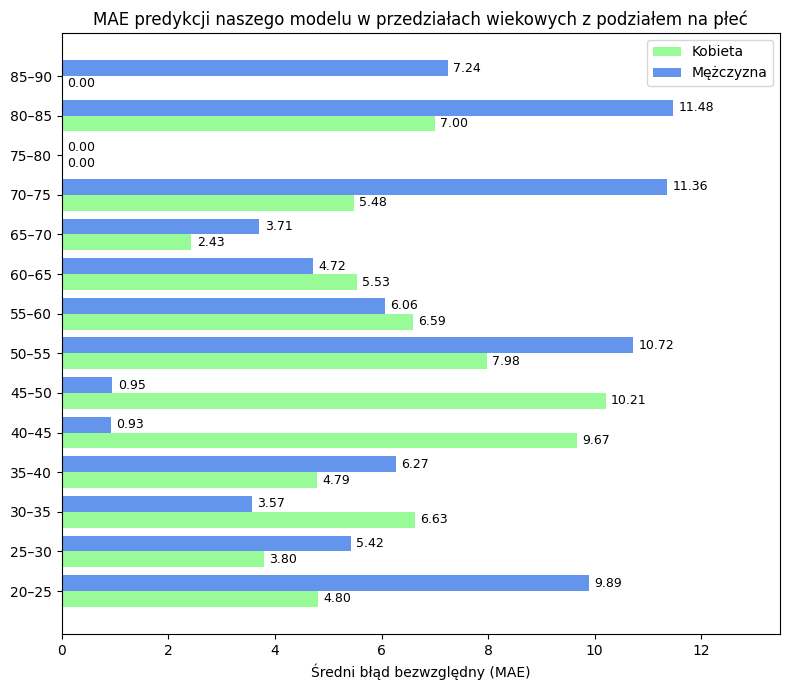

In [ ]:
bins = range(20, 95, 5)
new_model_preds["bin"] = pd.cut(new_model_preds["age_at_scan"], bins=bins, right=False)

# Dołączenie płci
merged = new_model_preds.merge(ixi_metadata[["IXI_ID", "SEX_ID (1=m, 2=f)"]].drop_duplicates(subset="IXI_ID"),
                               left_on="uid", right_on="IXI_ID", how="left")
merged["Płeć"] = merged["SEX_ID (1=m, 2=f)"].map({1: "Mężczyzna", 2: "Kobieta"})

# Biny uporządkowane
all_bins = pd.Categorical(pd.cut(pd.Series(bins[:-1]), bins=bins, right=False).unique(), ordered=True)
merged["bin"] = pd.Categorical(merged["bin"], categories=all_bins, ordered=True)

# MAE w przedziałach wg płci
mae_by_bin_gender = merged.groupby(["bin", "Płeć"], observed=True)[["predicted_age", "age_at_scan"]].apply(
    lambda g: np.mean(np.abs(g["predicted_age"] - g["age_at_scan"]))
).unstack(fill_value=0)

# Pełna kombinacja binów i płci
plec_kategorie = ["Kobieta", "Mężczyzna"]
mae_by_bin_gender = mae_by_bin_gender.reindex(index=all_bins, columns=plec_kategorie).fillna(0)

# Przygotowanie etykiet
labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in mae_by_bin_gender.index]
y = np.arange(len(labels))
bar_height = 0.4

# Wykres słupkowy MAE w przedziałach wiekowych dla poszczególnych płci
plt.figure(figsize=(8, 7))
plt.barh(y - bar_height/2, mae_by_bin_gender["Kobieta"], height=bar_height, color="palegreen", label="Kobieta")
plt.barh(y + bar_height/2, mae_by_bin_gender["Mężczyzna"], height=bar_height, color="cornflowerblue", label="Mężczyzna")

# Etykiety słupków
for i, v in enumerate(mae_by_bin_gender["Kobieta"]):
    plt.text(v + 0.1, y[i] - bar_height/2, f"{v:.2f}", va="center", fontsize=9)

for i, v in enumerate(mae_by_bin_gender["Mężczyzna"]):
    plt.text(v + 0.1, y[i] + bar_height/2, f"{v:.2f}", va="center", fontsize=9)

plt.yticks(ticks=y, labels=labels, ha='right')
plt.xlabel("Średni błąd bezwzględny (MAE)")
plt.xlim(0, mae_by_bin_gender.values.max() + 2)
plt.title("MAE predykcji naszego modelu w przedziałach wiekowych z podziałem na płeć")
plt.legend()
plt.tight_layout()
plt.show()